**Description**

В этом соревновании нужно написать сверточную нейронную сеть для классификации изображений.

Вам предоставлен датасет с изображениями рентгена грудной клетки, включая:

изображения с COVID-19
изображения с инфекциями, не связанными с COVID-19 (вирусная или бактериальная пневмония)
изображения здоровой грудной клетки
Размер обучающей выборки (train) - 27 тысяч изображений, тестовой выборки (test) - 7 тысяч изображений.

Для изображений из обучающей выборки также предоставлены точные маски сегментации легких.

---

In this competition you need to write a convolutional neural network for image classification.

You are provided with a dataset of chest x-ray images, including:

COVID-19 images
images of non-COVID-19 infections (viral or bacterial pneumonia)
healthy chest images
The size of the training sample (train) is 27 thousand images, the test sample (test) is 7 thousand images.

Accurate lung segmentation masks are also provided for images from the training set.

https://www.kaggle.com/competitions/ml-intensive-yandex-academy-spring-2024/overview

**Evaluation**

*f1-score*

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import re

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_segmentation_masks
from torchvision import transforms
from torchsummary import summary
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm

Основные параметры обучения

Basic training parameters

In [ ]:
TRAIN_PATH = "./data/train_images/*"
TRAIN_MASK = "./data/train_lung_masks/"
TEST_PATH = "./data/test_images/*"

SIZE = (144, 144)

BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EPOCHS = 50
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

Зафиксируем сид

Let's fix the seed

In [ ]:
def set_all_seeds(seed=42):
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()

# Загрузка данных | Loading Data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml-intensive-yandex-academy-spring-2024

 99% 979M/988M [00:14<00:00, 89.0MB/s]
100% 988M/988M [00:14<00:00, 73.2MB/s]


In [ ]:
!unzip "./ml-intensive-yandex-academy-spring-2024.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train_lung_masks/img_5499.png  
  inflating: data/train_lung_masks/img_55.png  
  inflating: data/train_lung_masks/img_550.png  
  inflating: data/train_lung_masks/img_5500.png  
  inflating: data/train_lung_masks/img_5501.png  
  inflating: data/train_lung_masks/img_5502.png  
  inflating: data/train_lung_masks/img_5503.png  
  inflating: data/train_lung_masks/img_5504.png  
  inflating: data/train_lung_masks/img_5505.png  
  inflating: data/train_lung_masks/img_5506.png  
  inflating: data/train_lung_masks/img_5507.png  
  inflating: data/train_lung_masks/img_5508.png  
  inflating: data/train_lung_masks/img_5509.png  
  inflating: data/train_lung_masks/img_551.png  
  inflating: data/train_lung_masks/img_5510.png  
  inflating: data/train_lung_masks/img_5511.png  
  inflating: data/train_lung_masks/img_5512.png  
  inflating: data/train_lung_masks/img_5513.png  
  inflating: data/train_lung_masks/i

In [ ]:
data = pd.read_csv("./data/train_answers.csv")
data.head()

,id,target_feature
0,0,0
1,1,2
2,2,2
3,3,0
4,4,1


# Исследование данных | Data Exploration

Посмотрим на баланс классов

Let's look at the class balance

In [ ]:
data.target_feature.value_counts()

target_feature
1    9546
2    8929
0    8525
Name: count, dtype: int64

Видно, что классы сбалансированы

It is clear that the classes are balanced

Давайте посмотрим на изображения.

Let's look at the image.

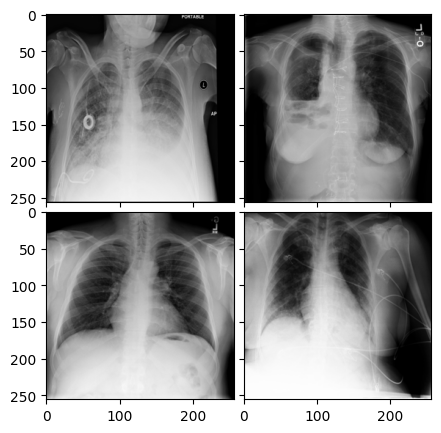

In [ ]:
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob(TRAIN_PATH)
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)]

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

А теперь на маски для обучающей выборки

And now onto the masks for the training set

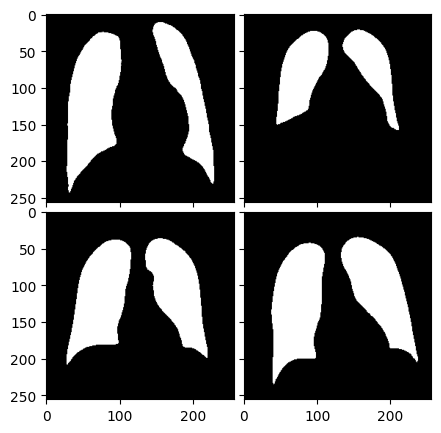

In [ ]:
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob(TRAIN_MASK + "*")
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)]

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

# Подготовка данных | Data preparation

Создадим кастомный датасет

Let's create a custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pathes, labels=None, transforms=None, mask_path=None):
        self.pathes = pathes
        self.transforms = transforms
        self.labels = labels
        self.mask_path = mask_path

    def __len__(self):
        return len(self.pathes)

    def __getitem__(self, index):
         img_path = self.pathes[index]
         img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

         if self.mask_path:
             mask = cv2.imread(self.mask_path + img_path.split("/")[-1])
             img = np.sign(np.sum(mask, axis=-1)) * img

         img = Image.fromarray(img.astype(np.uint8))
         if self.transforms:
             img = self.transforms(img)

         if self.labels is not None:
             id = re.search("\d+", img_path)[0]
             return img, data.loc[data.id == int(id), "target_feature"].values[0]
         else:
             return img


Определим трансформацию изображений

Let's define image transformation

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(size=SIZE),
    transforms.ToTensor(),                # Преобразовать в тензор | Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные | Normalize data
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),             # Горизонтальное отражение | Horizontal reflection
    transforms.Resize(size=SIZE),
    transforms.RandomRotation(degrees=10),         # Повороты до 10 градусов | Rotations up to 10 degrees
    transforms.ColorJitter(brightness=0.05),       # Случайное увеличение яркости на 0.2 | Random increase in brightness by 0.2
    transforms.ToTensor(),                         # Преобразование изображения в тензор | Converting an image to a tensor
    transforms.Normalize((0.5,), (0.5,))           # Нормализовать данные | Normalize data
])

In [ ]:
train_img, valid_img = train_test_split(data, test_size=0.2, stratify=data.target_feature)
train_img = list(map(lambda id: TRAIN_PATH[:-1] + f"img_{id}.png", train_img.id.values))
valid_img = list(map(lambda id: TRAIN_PATH[:-1] + f"img_{id}.png", valid_img.id.values))

In [ ]:
train_dataset = CustomDataset(train_img, labels=data, transforms=train_transform, mask_path=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
val_dataset = CustomDataset(valid_img, labels=data, transforms=test_transform, mask_path=None)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

test_dataset = CustomDataset(glob(TEST_PATH), labels=data, transforms=test_transform)
test_loader = DataLoader(train_dataset, batch_size=1, num_workers=2)

del train_dataset, test_dataset # Освободим память | Let's free up memory

Посмотрим на изображения после аугментации и применения масок

Let's look at the images after augmentation and application of masks

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


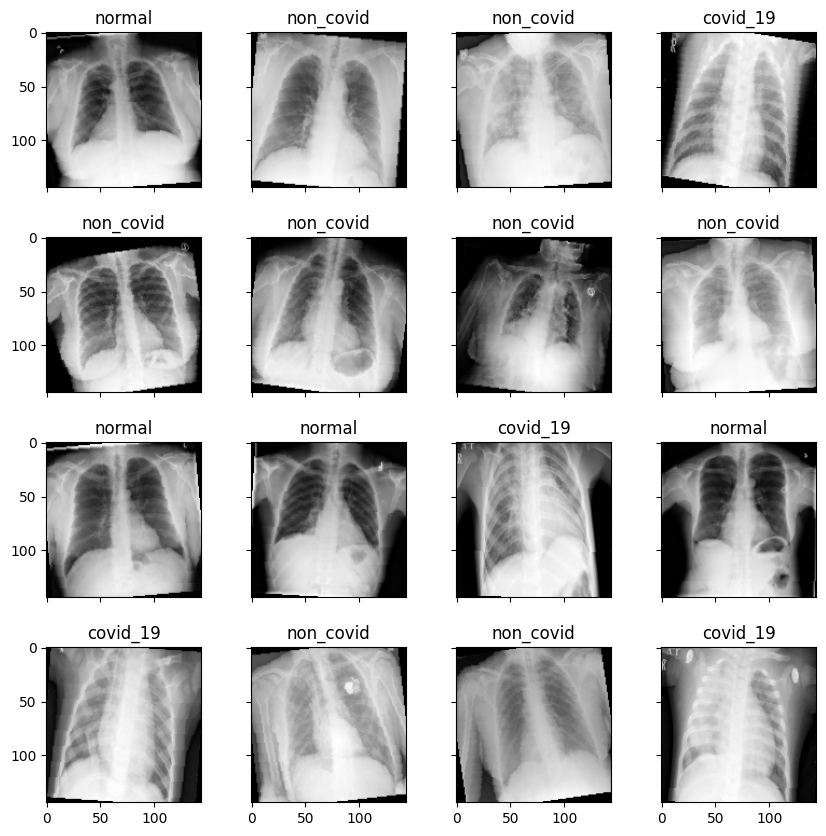

In [ ]:
classes = {0: "normal", 1: "non_covid", 2: "covid_19"}
batch = next(iter(train_loader))
images, labels = batch

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.5,
                 )

for ax, img, label in zip(grid, images, labels):
    ax.title.set_text(classes[label.item()])
    ax.imshow(img.permute(1, 2, 0), cmap="gray")

plt.show()

# Обучение | Training

In [ ]:
!mkdir ./models

Реализуем класс для ранней остановки

Implementing a class for early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.result = {}
        self.trace_func = trace_func

    def __call__(self, val_loss, ci, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, ci, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, ci, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, ci, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.result[self.path] = ci
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


Реализуем функции для обучения и оценки модели

We implement functions for training and evaluating the model

In [ ]:
def train_model(model, loader, optimizer, criterion, epochs, path="./", patience=5):
    result = {}
    early_stop = EarlyStopping(patience=min(patience, epochs), path=path)

    for epoch in range(epochs):
        model.train()
        print("EPOCH ", epoch+1)

        epoch_loss = 0
        y_trues, y_preds  = [], []

        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(x)

            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            y_trues.extend(y.detach().cpu())
            y_preds.extend(predictions.argmax(dim=1).tolist())

        print("Loss:", epoch_loss / len(loader))
        print("F1-SCORE:", f1_score(y_trues, y_preds, average="macro"), "\n")

        val_loss, accuracy = test(model, val_loader, criterion)
        early_stop(val_loss, accuracy, model)
        result.update(early_stop.result)

        if early_stop.early_stop:
              break

    return result


def test(model, loader, criterion=nn.BCELoss()):
    model.eval()
    loss = 0
    y_trues, y_preds = [], []

    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)

            predictions = model(x)
            loss += criterion(predictions, y).item()

            y_trues.extend(y.detach().cpu())
            y_preds.extend(predictions.argmax(dim=1).tolist())

        val_loss = loss/len(loader)
        f1 = f1_score(y_trues, y_preds, average="macro")
        print("Loss:", val_loss)
        print("F1-SCORE:", f1, "\n")

    return val_loss, f1


Напишем класс нейронной сети

Let's write a neural network class

## CNN

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               kernel_size,
               padding=(0, 0),
               stride=(1, 1),
               activation=nn.ReLU):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              padding=padding,
                              stride=stride)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activate = activation()

  def forward(self, x):
      x = self.norm(self.conv(x))
      out = self.activate(x)
      return out



class InceptionResNetA(nn.Module):
    def __init__(self,
                 channels):
      super(InceptionResNetA, self).__init__()
      self.conv1 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=32,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=32,
                                           out_channels=48,
                                           kernel_size=(3, 3),
                                           padding=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=48,
                                           out_channels=64,
                                           kernel_size=(3, 3),
                                           padding=(1, 1)),
                                 nn.ReLU(),)
      self.conv2 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=32,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=32,
                                           out_channels=32,
                                           kernel_size=(3, 3),
                                           padding=(1, 1)),
                                 nn.ReLU(),)
      self.conv3 = ConvBlock(in_channels=channels,
                             out_channels=32,
                             kernel_size=(1, 1))
      self.conv_out = ConvBlock(in_channels=128,
                                out_channels=channels,
                                kernel_size=(1, 1))
      self.relu = nn.ReLU()

    def forward(self, x):
      x1 = self.conv1(x)
      x2 = self.conv2(x)
      x3 = self.relu(self.conv3(x))

      x_full = torch.cat([x1, x2, x3], dim=1)
      out = self.relu(self.conv_out(x_full))
      out = out + x
      return out



class InceptionResNetB(nn.Module):
    def __init__(self,
                 channels):
      super(InceptionResNetB, self).__init__()
      self.conv1 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=128,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=128,
                                           out_channels=160,
                                           kernel_size=(1, 5)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=160,
                                           out_channels=192,
                                           kernel_size=(5, 1),
                                           padding=(2, 2)),
                                 nn.ReLU(),)
      self.conv2 = ConvBlock(in_channels=channels,
                             out_channels=192,
                             kernel_size=(3, 3),
                             padding=(1, 1))
      self.conv_out = ConvBlock(in_channels=384,
                                out_channels=channels,
                                kernel_size=(1, 1))
      self.relu = nn.ReLU()

    def forward(self, x):
      x1 = self.conv1(x)
      x2 = self.relu(self.conv2(x))

      x_full = torch.cat([x1, x2], dim=1)
      out = self.relu(self.conv_out(x_full))
      out = out + x
      return out



class InceptionResNetC(nn.Module):
    def __init__(self,
                 channels):
      super(InceptionResNetC, self).__init__()
      self.conv1 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=192,
                                           kernel_size=(1, 1),
                                           padding=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=192,
                                           out_channels=224,
                                           kernel_size=(1, 3)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=224,
                                           out_channels=256,
                                           kernel_size=(3, 1),),
                                 nn.ReLU(),)
      self.conv2 = ConvBlock(in_channels=channels,
                             out_channels=192,
                             kernel_size=(1, 1))
      self.conv_out = ConvBlock(in_channels=448,
                                out_channels=channels,
                                kernel_size=(1, 1))
      self.relu = nn.ReLU()

    def forward(self, x):
      x1 = self.conv1(x)
      x2 = self.relu(self.conv2(x))

      x_full = torch.cat([x1, x2], dim=1)
      out = self.relu(self.conv_out(x_full))
      out = out + x
      return out



class ReductionA(nn.Module):
    def __init__(self,
                 channels):
      super(ReductionA, self).__init__()
      self.conv1 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=256,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=256,
                                           out_channels=256,
                                           kernel_size=(3, 3),
                                           padding=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=256,
                                           out_channels=384,
                                           kernel_size=(3, 3),
                                           stride=(2, 2)),
                                 nn.ReLU(),)
      self.conv2 = ConvBlock(in_channels=channels,
                             out_channels=384,
                             kernel_size=(3, 3),
                             stride=(2, 2))
      self.pool = nn.MaxPool2d(kernel_size=(3, 3),
                               stride=2)
      self.relu = nn.ReLU()

    def forward(self, x):
      x1 = self.conv1(x)
      x2 = self.relu(self.conv2(x))
      out = torch.cat([x1, x2, self.pool(x)], dim=1)
      return out



class ReductionB(nn.Module):
    def __init__(self,
                 channels):
      super(ReductionB, self).__init__()
      self.conv1 = nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=256,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=256,
                                           out_channels=288,
                                           kernel_size=(3, 3),
                                           padding=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=288,
                                           out_channels=320,
                                           kernel_size=(3, 3),
                                           stride=(2, 2)),
                                 nn.ReLU(),)
      self.conv2 =  nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=256,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=256,
                                           out_channels=384,
                                           kernel_size=(3, 3),
                                           stride=(2, 2)),
                                 nn.ReLU(),)
      self.conv3 =  nn.Sequential(ConvBlock(in_channels=channels,
                                           out_channels=256,
                                           kernel_size=(1, 1)),
                                 nn.ReLU(),
                                 ConvBlock(in_channels=256,
                                           out_channels=288,
                                           kernel_size=(3, 3),
                                           stride=(2, 2)),
                                 nn.ReLU(),)
      self.pool = nn.MaxPool2d(kernel_size=(3, 3),
                               stride=(2, 2))

    def forward(self, x):
      x1 = self.conv1(x)
      x2 = self.conv2(x)
      x3 = self.conv3(x)
      x4 = self.pool(x)

      out = torch.cat([x1, x2, x3, x4], dim=1)
      return out



class StemBlock(nn.Module):
    def __init__(self):
      super(StemBlock, self).__init__()
      self.stem_in = nn.Sequential(ConvBlock(in_channels=1,
                                              out_channels=32,
                                              kernel_size=(3, 3),
                                              stride=(2, 2),
                                              padding=(0, 0)),
                                    nn.ReLU(),
                                    ConvBlock(in_channels=32,
                                              out_channels=32,
                                              kernel_size=(3, 3),
                                              stride=(1, 1),
                                              padding=(0, 0)),
                                    nn.ReLU(),
                                    ConvBlock(in_channels=32,
                                              out_channels=32,
                                              kernel_size=(3, 3),
                                              stride=(1,),
                                              padding=(1, 1)),
                                   nn.ReLU())
      self.stem_out = nn.Sequential(ConvBlock(in_channels=32,
                                              out_channels=80,
                                              kernel_size=(1, 1),
                                              stride=(1, 1),
                                              padding=(0, 0)),
                                    nn.ReLU(),
                                    ConvBlock(in_channels=80,
                                              out_channels=64,
                                              kernel_size=(1, 1),
                                              stride=(1, 1),
                                              padding=(0, 0)),
                                    nn.ReLU())
      self.max_pool = nn.MaxPool2d(kernel_size=(3, 3),
                                   stride=(2, 2))

    def forward(self, x):
      x = self.max_pool(self.stem_in(x))
      x = self.max_pool(self.stem_out(x))
      return x



class InceptionResNet(nn.Module):
    def __init__(self,
                 channels,
                 final_channels):
        super(InceptionResNet, self).__init__()
        self.stem = StemBlock(channels)
        self.inceptionResA = nn.ModuleList([InceptionResNetA(channels) for _ in range(5)])
        self.reductionA = ReductionA(channels)

        self.inceptionResB = nn.ModuleList([InceptionResNetB(1152) for _ in range(10)])
        self.reductionB = ReductionB(1152)

        self.inceptionResC = nn.ModuleList([InceptionResNetC(2144) for _ in range(5)])
        self.final_conv = ConvBlock(in_channels=2144,
                                    out_channels=final_channels,
                                    kernel_size=(1, 1))
        self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.classifier = nn.Sequential(nn.Dropout(0.6),
                                        nn.Linear(final_channels , 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 3))

    def forward(self, x):
        batch = x.size(0)

        x = self.stem(x)
        for layer in self.inceptionResA:
          x = layer(x)

        x = self.reductionA(x)
        for layer in self.inceptionResB:
          x = layer(x)

        x = self.reductionB(x)
        for layer in self.inceptionResC:
          x = layer(x)

        x = self.final_conv(x)
        x = self.global_pool(x)
        x = x.view(batch, -1)
        out = self.classifier(x)
        return out


In [ ]:
model = InceptionResNet(64, 2048).to(DEVICE)
summary(model, (1, *SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 71, 71]             320
       BatchNorm2d-2           [-1, 32, 71, 71]              64
              ReLU-3           [-1, 32, 71, 71]               0
         ConvBlock-4           [-1, 32, 71, 71]               0
              ReLU-5           [-1, 32, 71, 71]               0
            Conv2d-6           [-1, 32, 69, 69]           9,248
       BatchNorm2d-7           [-1, 32, 69, 69]              64
              ReLU-8           [-1, 32, 69, 69]               0
         ConvBlock-9           [-1, 32, 69, 69]               0
             ReLU-10           [-1, 32, 69, 69]               0
           Conv2d-11           [-1, 32, 69, 69]           9,248
      BatchNorm2d-12           [-1, 32, 69, 69]              64
             ReLU-13           [-1, 32, 69, 69]               0
        ConvBlock-14           [-1, 32,

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

train_model(model, train_loader, optimizer, criterion, 100, path="./models/model.pt")

EPOCH  1


100%|██████████| 675/675 [02:21<00:00,  4.78it/s]


Loss: 0.6546847105467761
F1-SCORE: 0.7232225286989876 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 14.22it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.69it/s]


Loss: 0.4339543817311349
F1-SCORE: 0.8293786312624024 

EPOCH  2


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:21<00:00,  5.01it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:21<00:00,  4.78it/s]


Loss: 0.4450740977128347
F1-SCORE: 0.8215612560814032 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:14<00:00,  9.13it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.30it/s]


Loss: 0.40094981659975276
F1-SCORE: 0.843754216271282 

EPOCH  3


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:33<00:00,  4.73it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:33<00:00,  4.39it/s]


Loss: 0.3869866825474633
F1-SCORE: 0.8479260123713307 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 15.36it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.97it/s]


Loss: 0.3913247863040168
F1-SCORE: 0.847263870455437 

EPOCH  4


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:25<00:00,  5.03it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:25<00:00,  4.63it/s]


Loss: 0.35076404052752036
F1-SCORE: 0.8652282029545217 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:22<00:00, 11.24it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:23<00:00,  7.32it/s]


Loss: 0.37297421371972067
F1-SCORE: 0.8513550094070671 

EPOCH  5


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:45<00:00,  4.50it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:46<00:00,  4.07it/s]


Loss: 0.3267736202919925
F1-SCORE: 0.8727152556630666 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:18<00:00,  7.30it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:19<00:00,  8.81it/s]


Loss: 0.31029800923001133
F1-SCORE: 0.8840220120306338 

EPOCH  6


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:39<00:00,  4.23it/s]


Loss: 0.3051965293840126
F1-SCORE: 0.881735290087715 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:20<00:00,  8.07it/s]


Loss: 0.2782917396556696
F1-SCORE: 0.8965846829022653 

EPOCH  7


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:33<00:00,  4.99it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:33<00:00,  4.39it/s]


Loss: 0.28815911496678986
F1-SCORE: 0.8877340558611756 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:17<00:00, 10.16it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:17<00:00,  9.59it/s]


Loss: 0.2822073010959216
F1-SCORE: 0.8970751556555877 

EarlyStopping counter: 1 out of 5
EPOCH  8


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:43<00:00,  4.13it/s]


Loss: 0.277389343060829
F1-SCORE: 0.8937699388594093 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:18<00:00, 11.74it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:18<00:00,  9.33it/s]


Loss: 0.3140019380746508
F1-SCORE: 0.8822746356367478 

EarlyStopping counter: 2 out of 5
EPOCH  9


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:39<00:00,  4.26it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:40<00:00,  4.22it/s]


Loss: 0.2634056652364907
F1-SCORE: 0.8972146962792307 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:17<00:00, 14.20it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:17<00:00,  9.50it/s]


Loss: 0.2756019862666285
F1-SCORE: 0.898515479367334 

EPOCH  10


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:36<00:00,  4.98it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:36<00:00,  4.31it/s]


Loss: 0.2506637538472811
F1-SCORE: 0.9040504081798316 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 14.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.51it/s]


Loss: 0.28591186892704146
F1-SCORE: 0.8924959159976366 

EarlyStopping counter: 1 out of 5
EPOCH  11


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.74it/s]


Loss: 0.23801277586155467
F1-SCORE: 0.9094590583694208 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 15.16it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.41it/s]


Loss: 0.2806300308841925
F1-SCORE: 0.8935865746092192 

EarlyStopping counter: 2 out of 5
EPOCH  12


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:23<00:00,  4.71it/s]


Loss: 0.2310853703789137
F1-SCORE: 0.9112139594432184 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 14.86it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.42it/s]


Loss: 0.282176223313491
F1-SCORE: 0.8946861534863526 

EarlyStopping counter: 3 out of 5
EPOCH  13


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.75it/s]


Loss: 0.2194621462236952
F1-SCORE: 0.9161154491193023 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 12.92it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.51it/s]


Loss: 0.2764592304958042
F1-SCORE: 0.8997832860775775 

EarlyStopping counter: 4 out of 5
EPOCH  14


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.99it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.74it/s]


Loss: 0.2095060419512016
F1-SCORE: 0.920353925643023 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 14.64it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.62it/s]


Loss: 0.25813775273734296
F1-SCORE: 0.9082345085990244 

EPOCH  15


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:21<00:00,  4.76it/s]


Loss: 0.20890901429233727
F1-SCORE: 0.9191936825390133 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 10.30it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 11.21it/s]


Loss: 0.29157457293490685
F1-SCORE: 0.8978257822705888 

EarlyStopping counter: 1 out of 5
EPOCH  16


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.97it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.74it/s]


Loss: 0.2009331617090437
F1-SCORE: 0.9221795519620253 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 15.09it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.55it/s]


Loss: 0.2524485147321189
F1-SCORE: 0.9122757792001828 

EPOCH  17


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:21<00:00,  4.88it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:22<00:00,  4.75it/s]


Loss: 0.18970551965689217
F1-SCORE: 0.925971107417197 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:14<00:00, 13.80it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.84it/s]


Loss: 0.2844377312390409
F1-SCORE: 0.9031847762175613 

EarlyStopping counter: 1 out of 5
EPOCH  18


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:23<00:00,  4.70it/s]


Loss: 0.18453367006723528
F1-SCORE: 0.9288043572267369 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 14.57it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 11.19it/s]


Loss: 0.30585980964218373
F1-SCORE: 0.8960114492976499 

EarlyStopping counter: 2 out of 5
EPOCH  19


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:24<00:00,  4.93it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:24<00:00,  4.68it/s]


Loss: 0.17729258278591764
F1-SCORE: 0.9318668284720305 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 13.89it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:15<00:00, 11.15it/s]


Loss: 0.28677942428583575
F1-SCORE: 0.9089245533170125 

EarlyStopping counter: 3 out of 5
EPOCH  20


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:23<00:00,  4.71it/s]


Loss: 0.17079471405457566
F1-SCORE: 0.9341203012674058 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 14.10it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.27it/s]


Loss: 0.2595493564569562
F1-SCORE: 0.9132130933114223 

EarlyStopping counter: 4 out of 5
EPOCH  21


  0%|          | 0/675 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:23<00:00,  5.00it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 675/675 [02:23<00:00,  4.69it/s]


Loss: 0.16395027086414674
F1-SCORE: 0.9355599416469764 



  0%|          | 0/169 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▉| 168/169 [00:14<00:00, 14.41it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 169/169 [00:14<00:00, 11.57it/s]


Loss: 0.26675212085687905
F1-SCORE: 0.919291191717765 

EarlyStopping counter: 5 out of 5


{'./models/model.pt': 0.9122757792001828}